- Threshold policy: As we change threshold, look at p
- w-Lookahead policy: As we change w, look at p

We compare the average queue length of the two models as p changes.

We make some key changes to see if we can match Spencer et al. results

- the fast service rate to 0 (jobs get deleted)
- instead of looking at the proportion of time that we are in surge, we look at the proportion of jobs that get kicked out 
- Spencer et al. uses p to denote 1-slow service rate so we use alpha instead of p for the proportion of jobs that get kicked out

In [1]:
%matplotlib inline
from pylab import *
import sys
from collections import namedtuple
import random
import time
import numpy as np

In [2]:
def log_normal(mu=0, sigma=1):
    return e**(mu+sigma*np.random.normal())

def exp_samples(lambd=1,n=1):
    """
    generates a numpy array of n samples distributed according to
    an exponential distribution with parameter λ
    """
    random.seed(time.time())
    return (-1/lambd)*log(rand(n))

def exp(lambd=1):
    """
    generates a sample distributed according to
    an exponential distribution with parameter λ
    """
    if lambd < 0:
        return inf()
    random.seed(time.time())
    return (-1/lambd)*log(rand())

def inf():
    return 999999


def printarray(a): 
    print(np.around(a, 3))
    

# Define customer for the threshold policy
Customer = namedtuple("Customer", "arrival_time")
def customer(arrival_time=-1):
    return Customer(arrival_time=arrival_time)

# Define customer for the w-lookahead policy
# mu1 is the slow service rate and mu2 is the fast service rate
WCustomer = namedtuple("WCustomer", "arrival_time slow_service_time fast_service_time enter_service_time service_time arrival_index fast")
def wcustomer(arrival_time=-1, mu1=-1, mu2=-1, arrival_index=0):
    slow = exp(mu1)
    fast = 0 #slow * mu1/mu2
    return WCustomer(arrival_time=arrival_time, slow_service_time=slow,
                     fast_service_time=fast, enter_service_time=-1,
                     service_time=-1, arrival_index=arrival_index, fast=False)

def wcustomer_with_parameters(w, current_time, fast):
    if fast:
        return WCustomer(arrival_time=w.arrival_time, slow_service_time=w.slow_service_time,
                         fast_service_time=w.fast_service_time, enter_service_time=current_time,
                         service_time=current_time+w.fast_service_time,
                         arrival_index=w.arrival_index, fast=True)
    return WCustomer(arrival_time=w.arrival_time, slow_service_time=w.slow_service_time,
                     fast_service_time=w.fast_service_time, enter_service_time=current_time,
                     service_time=current_time+w.slow_service_time,
                     arrival_index=w.arrival_index, fast=False)

In [28]:
# Example 2: M/M/1 queue starting as empty
# lambd = arrival rate
# mu1 = pre-surge service rate
# mu2 = post-surge service rate
# surge_threshold = the queue length to activate surge at
# c = number of servers (1)
# N0 = starting number in the queue
# Tmax = time horizon

def MM1WithOneThreshold(lambd, mu1, mu2, surge_threshold, c, N0, Tmax):
    T             = [0]  # list of times that events occur
    t_temp        = 0    # temporary time to calculate delta
    N             = [N0] # initial state of the system
    S             = 0    # area under curve starting with T=1000
    in_surge      = 0    # time spent in surge
    start_measuring_surge = 0
    end_measuring_surge = 0
    use_surge_num = 0
    use_surge_denom = 0
    
    # customers currently being served by a server
    servers = [customer(0) for _ in range(min(c, N0))]
    
    # customers that are waiting to be served by a server
    queue = [customer(0) for _ in range(N0 - c)]
    
    # times spent by users inside the system
    waiting_times = []
    
    while T[-1] < Tmax:
        t_temp = T[-1]
        event_rate = lambd + mu1*(0 < N[-1] and N[-1] < surge_threshold)# + mu2*(surge_threshold <= N[-1])
        if N[-1] >= surge_threshold:
            next_event = 0
            event = 1
            use_surge_num += 1
        else:
            next_event = exp(event_rate)
            event = rand()
        T.append(t_temp + next_event)
        
            
        ##### ARRIVAL ##### 
        if event < lambd / event_rate:
            N.append(N[-1] + 1) 
            if len(servers) < c:
                servers.append(customer(T[-1]))
            else:
                queue.append(customer(T[-1]))
        ##### DEPARTURE #####     
        else:
            N.append(N[-1] - 1)
            popped_customer = servers.pop(0)
            T_in = popped_customer.arrival_time
            if T_in>0:
                waiting_times.append(T[-1] - T_in)            
            if len(queue) > 0:
                next_to_enter = queue.pop(0)
                servers.append(customer(next_to_enter.arrival_time))
            use_surge_denom += 1
        
        ##### SURGE count and proportion #####
        if T[-1] > 1000 and T[-1] < 9000:
            if in_surge == 0 and S == 0: # first time, mark t_temp
                start_measuring_surge = T[-2]
            t_delta = T[-1] - T[-2]
            S = S + (t_delta * N[-2])
            if N[-2] >= surge_threshold:
                in_surge = in_surge + t_delta
        if T[-1] > 9000:
                if end_measuring_surge == 0:
                    end_measuring_surge = T[-1]

    S = S / (end_measuring_surge - start_measuring_surge)
    in_surge = in_surge / (end_measuring_surge - start_measuring_surge)
    # discard Tmax
    T = T[:-1] 
    N = N[:-1]
    return T, N, waiting_times, S, use_surge_num / use_surge_denom

In [51]:
# Example 2: M/M/1 queue starting as empty
# lambd = arrival rate
# mu1 = pre-surge service rate
# mu2 = post-surge service rate
# c = number of servers (1)
# w = the amount of time to look ahead
# Tmax = time horizon

# Heuristic:  upon beginning of service, look w-ahead. if the # departures in
# that time < # arrivals at the slow service rate, use the fast service rate.
# otherwise, use the slow service rate

# Constant arrival and departure rates for testing whether this works

def MM1WithWLookaheadConstant(lambd, mu1, mu2, c, w, Tmax):
    T             = [0]  # list of times that events occur in real time
    T_advance     = [0]  # list of events that get generated in advance
    t_temp        = 0    # temporary time to calculate delta
    N             = [0] # initial state of the system
    S             = 0    # area under curve starting with T=1000
    in_surge      = 0    # time spent in surge
    start_measuring_surge = 0
    end_measuring_surge = 0
    p_wait_num = 0
    p_wait_denom = 0
    use_surge_num = 0
    use_surge_denom = 0
    
    # customers currently being served by a server
    servers = []
    
    # customers that are waiting to be served by a server
    queue = []
    
    # times spent by users inside the system
    waiting_times = []
    
    # generate arrivals independent of whether or not we speed up the customers
    arrivals = []
    while T_advance[-1] < Tmax:
        t_temp = T_advance[-1]
        next_arrival = t_temp + exp(lambd)
        T_advance.append(next_arrival)
        arrivals.append(wcustomer(next_arrival, mu1, mu2, len(T_advance) - 2))
    #print(arrivals)
    
    # arrival index represents when we either add to queue or to server if it's free
    arrival_index = 0
    
    # first event must be an arrival
    next_arrival = arrivals[arrival_index].arrival_time
    next_departure = inf()
    
    while T[-1] < Tmax:
        t_temp = T[-1]
        
        T.append(min(next_arrival, next_departure))
        
        ##### ARRIVAL ##### 
        if T[-1] == next_arrival:
            N.append(N[-1]+1) 
            arrival = arrivals[arrival_index]
            arrival_index += 1
            if len(servers) < c:
                # w-lookahead: decide whether to use fast or slow service rate
                cumulative_service_time = T[-1]
                w_lookahead = T[-1] + w
                num_arrivals = 0
                num_departures = 0
                for i in range(arrival_index, len(arrivals) - 1):
                    if arrivals[i].arrival_time > min(w_lookahead, Tmax):
                        break
                    else:
                        num_arrivals += 1
                for i in range(arrival.arrival_index - 1, len(arrivals) - 1):
                    cumulative_service_time += arrivals[i].slow_service_time
                    if cumulative_service_time > min(w_lookahead, Tmax):
                        break
                    else:
                        num_departures += 1
                if num_departures >= num_arrivals: # use the slow service rate   
                    servers.append(wcustomer_with_parameters(arrival, T[-1], False))
                    print("Look ahead at time %.3f has Departures %d Arrivals %d -> use SLOW" % (T[-1], num_departures, num_arrivals))
                else: # use the fast service rate
                    servers.append(wcustomer_with_parameters(arrival, T[-1], True))
                    if T[-1] > 1000:
                        use_surge_num += 1
                    print("Look ahead at time %.3f has Departures %d Arrivals %d -> use FAST" % (T[-1], num_departures, num_arrivals))
                if T[-1] > 1000:
                    use_surge_denom += 1
            else:
                queue.append(arrival)
                p_wait_num += 1
            p_wait_denom+=1
            #print("ARRIVAL %.3f departure %.3f abandonment %.3f" % (next_arrival, next_departure, next_abandonment))
        ##### DEPARTURE #####     
        elif T[-1] == next_departure:
            N.append(N[-1]-1)
            popped_customer = servers.pop(0)
            T_in = popped_customer.arrival_time
            if T_in>0:
                waiting_times.append(T[-1] - T_in)
                ##### SURGE count and proportion #####
            if T[-1] >= 1000 and T[-1] <= 9000:
                if in_surge == 0 and S == 0: # first time, mark t_temp
                    start_measuring_surge = T[-2]
                t_delta = T[-1] - popped_customer.enter_service_time
                S = S + (t_delta * N[-2])
                if popped_customer.fast:
                    in_surge = in_surge + t_delta
            if T[-1] > 9000:
                if end_measuring_surge == 0:
                    end_measuring_surge = T[-1]
            # put the next person from the queue into the server
            if len(queue) > 0:
                next_to_enter = queue.pop(0)
                # w-lookahead: decide whether to use fast or slow service rate
                cumulative_service_time = T[-1]
                w_lookahead = T[-1] + w
                num_arrivals = 0
                num_departures = 0
                for i in range(arrival_index, len(arrivals) - 1):
                    if arrivals[i].arrival_time > min(w_lookahead, Tmax):
                        break
                    else:
                        num_arrivals += 1
                for i in range(arrival.arrival_index - 1, len(arrivals) - 1):
                    cumulative_service_time += arrivals[i].slow_service_time
                    if cumulative_service_time > min(w_lookahead, Tmax):
                        break
                    else:
                        num_departures += 1
                if num_departures >= num_arrivals: # use the slow service rate   
                    servers.append(wcustomer_with_parameters(next_to_enter, T[-1], False))
                    print("Look ahead at time %.3f has Departures %d Arrivals %d -> use SLOW" % (T[-1], num_departures, num_arrivals))
                else: # use the fast service rate
                    servers.append(wcustomer_with_parameters(next_to_enter, T[-1], True))
                    if T[-1] > 1000:
                        use_surge_num += 1
                    print("Look ahead at time %.3f has Departures %d Arrivals %d -> use FAST" % (T[-1], num_departures, num_arrivals))
                if T[-1] > 1000:
                    use_surge_denom += 1
        
        if arrival_index < len(arrivals):
            next_arrival = arrivals[arrival_index].arrival_time
        else:
            next_arrival = inf()
        
        if len(servers) > 0:
            next_departure = servers[0].service_time
        else:
            next_departure = inf()
        
        #print("Next arrival %.3f Next departure %.3f" % (next_arrival, next_departure))
        

    S = S / (end_measuring_surge - start_measuring_surge)
    in_surge = in_surge / (end_measuring_surge - start_measuring_surge)
    # discard Tmax
    T = T[:-1] 
    N = N[:-1]
    return T, N, waiting_times, S, use_surge_num / use_surge_denom

In [52]:
lambd = 0.999
mu1 = 0.95
mu2 = 100 # doesn't matter because fast gets kicked out immediately
c = 1
N0 = 0
Tmax = 10000


surge_threshold = 2
w = 100

In [53]:
w_lookahead_x = []
w_lookahead_y = []

ws = [10000] #[1.5, 2, 3, 4, 5, 10, 20, 50, 100, 200, 500, 1000]

for w in ws:
    s = """\n%.2f Time lookahead.""" % (w)
    print(s)
    start = time.time()
    T, N, W, S, in_surge = MM1WithWLookaheadConstant(lambd, mu1, mu2, c, w, Tmax)
    end = time.time()
    figure(figsize=(15,6))
    plot(T[:int(len(T)*0.9)], N[:int(len(T)*0.9)])
    xlabel('Time')
    ylabel('Number of clients')
    title('Number of clients in the M/[slow M+fast M]/C queue %.2f/%.2f+%.2f/%d, with %.2f-time lookahead'
          % (lambd, mu1, mu2, c, w))

    print("Average queue length %.3f"%(S))
    print("P in surge %.3f"%(in_surge))
    print("Computed in %.3f seconds" % (end-start))
    w_lookahead_x.append(in_surge)
    w_lookahead_y.append(S)


10000.00 Time lookahead.
Look ahead at time 0.404 has Departures 9457 Arrivals 10108 -> use FAST
Look ahead at time 1.748 has Departures 9456 Arrivals 10107 -> use FAST
Look ahead at time 2.236 has Departures 9455 Arrivals 10106 -> use FAST
Look ahead at time 2.550 has Departures 9454 Arrivals 10105 -> use FAST
Look ahead at time 2.944 has Departures 9454 Arrivals 10104 -> use FAST
Look ahead at time 3.471 has Departures 9454 Arrivals 10103 -> use FAST
Look ahead at time 3.923 has Departures 9453 Arrivals 10102 -> use FAST
Look ahead at time 4.061 has Departures 9452 Arrivals 10101 -> use FAST
Look ahead at time 4.066 has Departures 9451 Arrivals 10100 -> use FAST
Look ahead at time 4.551 has Departures 9450 Arrivals 10099 -> use FAST
Look ahead at time 4.809 has Departures 9449 Arrivals 10098 -> use FAST
Look ahead at time 4.979 has Departures 9448 Arrivals 10097 -> use FAST
Look ahead at time 5.043 has Departures 9448 Arrivals 10096 -> use FAST
Look ahead at time 5.429 has Departure

Look ahead at time 99.488 has Departures 9353 Arrivals 9990 -> use FAST
Look ahead at time 99.494 has Departures 9352 Arrivals 9989 -> use FAST
Look ahead at time 99.702 has Departures 9352 Arrivals 9988 -> use FAST
Look ahead at time 101.570 has Departures 9350 Arrivals 9987 -> use FAST
Look ahead at time 102.025 has Departures 9350 Arrivals 9986 -> use FAST
Look ahead at time 104.689 has Departures 9349 Arrivals 9985 -> use FAST
Look ahead at time 106.066 has Departures 9347 Arrivals 9984 -> use FAST
Look ahead at time 106.626 has Departures 9347 Arrivals 9983 -> use FAST
Look ahead at time 106.769 has Departures 9346 Arrivals 9982 -> use FAST
Look ahead at time 106.870 has Departures 9345 Arrivals 9981 -> use FAST
Look ahead at time 108.103 has Departures 9344 Arrivals 9980 -> use FAST
Look ahead at time 108.403 has Departures 9349 Arrivals 9979 -> use FAST
Look ahead at time 111.149 has Departures 9347 Arrivals 9978 -> use FAST
Look ahead at time 111.586 has Departures 9346 Arrival

Look ahead at time 215.252 has Departures 9245 Arrivals 9874 -> use FAST
Look ahead at time 216.877 has Departures 9244 Arrivals 9873 -> use FAST
Look ahead at time 217.613 has Departures 9244 Arrivals 9872 -> use FAST
Look ahead at time 217.850 has Departures 9244 Arrivals 9871 -> use FAST
Look ahead at time 217.887 has Departures 9244 Arrivals 9870 -> use FAST
Look ahead at time 218.969 has Departures 9243 Arrivals 9869 -> use FAST
Look ahead at time 220.295 has Departures 9242 Arrivals 9868 -> use FAST
Look ahead at time 221.075 has Departures 9241 Arrivals 9867 -> use FAST
Look ahead at time 221.135 has Departures 9240 Arrivals 9866 -> use FAST
Look ahead at time 224.580 has Departures 9237 Arrivals 9865 -> use FAST
Look ahead at time 224.934 has Departures 9236 Arrivals 9864 -> use FAST
Look ahead at time 225.606 has Departures 9235 Arrivals 9863 -> use FAST
Look ahead at time 226.321 has Departures 9236 Arrivals 9862 -> use FAST
Look ahead at time 226.727 has Departures 9236 Arri

Look ahead at time 316.476 has Departures 9159 Arrivals 9762 -> use FAST
Look ahead at time 318.483 has Departures 9158 Arrivals 9761 -> use FAST
Look ahead at time 319.730 has Departures 9157 Arrivals 9760 -> use FAST
Look ahead at time 319.756 has Departures 9156 Arrivals 9759 -> use FAST
Look ahead at time 320.760 has Departures 9154 Arrivals 9758 -> use FAST
Look ahead at time 321.509 has Departures 9153 Arrivals 9757 -> use FAST
Look ahead at time 323.263 has Departures 9148 Arrivals 9756 -> use FAST
Look ahead at time 323.802 has Departures 9147 Arrivals 9755 -> use FAST
Look ahead at time 324.210 has Departures 9151 Arrivals 9754 -> use FAST
Look ahead at time 324.291 has Departures 9150 Arrivals 9753 -> use FAST
Look ahead at time 327.454 has Departures 9148 Arrivals 9752 -> use FAST
Look ahead at time 327.646 has Departures 9148 Arrivals 9751 -> use FAST
Look ahead at time 329.506 has Departures 9146 Arrivals 9750 -> use FAST
Look ahead at time 330.589 has Departures 9146 Arri

Look ahead at time 429.287 has Departures 9052 Arrivals 9638 -> use FAST
Look ahead at time 430.886 has Departures 9049 Arrivals 9637 -> use FAST
Look ahead at time 433.431 has Departures 9048 Arrivals 9636 -> use FAST
Look ahead at time 435.569 has Departures 9047 Arrivals 9635 -> use FAST
Look ahead at time 439.951 has Departures 9045 Arrivals 9634 -> use FAST
Look ahead at time 441.729 has Departures 9044 Arrivals 9633 -> use FAST
Look ahead at time 442.392 has Departures 9043 Arrivals 9632 -> use FAST
Look ahead at time 442.836 has Departures 9042 Arrivals 9631 -> use FAST
Look ahead at time 443.975 has Departures 9041 Arrivals 9630 -> use FAST
Look ahead at time 445.592 has Departures 9040 Arrivals 9629 -> use FAST
Look ahead at time 448.193 has Departures 9035 Arrivals 9628 -> use FAST
Look ahead at time 450.535 has Departures 9033 Arrivals 9627 -> use FAST
Look ahead at time 450.788 has Departures 9033 Arrivals 9626 -> use FAST
Look ahead at time 451.550 has Departures 9033 Arri

Look ahead at time 571.787 has Departures 8932 Arrivals 9521 -> use FAST
Look ahead at time 572.323 has Departures 8929 Arrivals 9520 -> use FAST
Look ahead at time 572.751 has Departures 8930 Arrivals 9519 -> use FAST
Look ahead at time 572.780 has Departures 8929 Arrivals 9518 -> use FAST
Look ahead at time 572.990 has Departures 8928 Arrivals 9517 -> use FAST
Look ahead at time 573.778 has Departures 8927 Arrivals 9516 -> use FAST
Look ahead at time 573.813 has Departures 8927 Arrivals 9515 -> use FAST
Look ahead at time 573.820 has Departures 8926 Arrivals 9514 -> use FAST
Look ahead at time 576.342 has Departures 8924 Arrivals 9513 -> use FAST
Look ahead at time 577.223 has Departures 8924 Arrivals 9512 -> use FAST
Look ahead at time 578.032 has Departures 8923 Arrivals 9511 -> use FAST
Look ahead at time 580.815 has Departures 8920 Arrivals 9510 -> use FAST
Look ahead at time 581.088 has Departures 8920 Arrivals 9509 -> use FAST
Look ahead at time 582.197 has Departures 8920 Arri

Look ahead at time 679.872 has Departures 8828 Arrivals 9400 -> use FAST
Look ahead at time 680.291 has Departures 8827 Arrivals 9399 -> use FAST
Look ahead at time 683.208 has Departures 8825 Arrivals 9398 -> use FAST
Look ahead at time 683.242 has Departures 8825 Arrivals 9397 -> use FAST
Look ahead at time 683.321 has Departures 8824 Arrivals 9396 -> use FAST
Look ahead at time 684.165 has Departures 8824 Arrivals 9395 -> use FAST
Look ahead at time 684.319 has Departures 8824 Arrivals 9394 -> use FAST
Look ahead at time 684.969 has Departures 8823 Arrivals 9393 -> use FAST
Look ahead at time 688.531 has Departures 8820 Arrivals 9392 -> use FAST
Look ahead at time 689.452 has Departures 8819 Arrivals 9391 -> use FAST
Look ahead at time 690.351 has Departures 8818 Arrivals 9390 -> use FAST
Look ahead at time 691.135 has Departures 8817 Arrivals 9389 -> use FAST
Look ahead at time 691.729 has Departures 8816 Arrivals 9388 -> use FAST
Look ahead at time 692.725 has Departures 8815 Arri

Look ahead at time 799.551 has Departures 8718 Arrivals 9278 -> use FAST
Look ahead at time 799.889 has Departures 8717 Arrivals 9277 -> use FAST
Look ahead at time 801.850 has Departures 8714 Arrivals 9276 -> use FAST
Look ahead at time 803.787 has Departures 8712 Arrivals 9275 -> use FAST
Look ahead at time 804.816 has Departures 8711 Arrivals 9274 -> use FAST
Look ahead at time 804.897 has Departures 8710 Arrivals 9273 -> use FAST
Look ahead at time 804.980 has Departures 8710 Arrivals 9272 -> use FAST
Look ahead at time 807.539 has Departures 8709 Arrivals 9271 -> use FAST
Look ahead at time 807.633 has Departures 8710 Arrivals 9270 -> use FAST
Look ahead at time 808.057 has Departures 8709 Arrivals 9269 -> use FAST
Look ahead at time 810.763 has Departures 8705 Arrivals 9268 -> use FAST
Look ahead at time 810.890 has Departures 8704 Arrivals 9267 -> use FAST
Look ahead at time 811.247 has Departures 8704 Arrivals 9266 -> use FAST
Look ahead at time 811.555 has Departures 8703 Arri

Look ahead at time 922.689 has Departures 8594 Arrivals 9152 -> use FAST
Look ahead at time 923.318 has Departures 8594 Arrivals 9151 -> use FAST
Look ahead at time 930.397 has Departures 8591 Arrivals 9150 -> use FAST
Look ahead at time 930.517 has Departures 8591 Arrivals 9149 -> use FAST
Look ahead at time 930.899 has Departures 8590 Arrivals 9148 -> use FAST
Look ahead at time 932.244 has Departures 8589 Arrivals 9147 -> use FAST
Look ahead at time 932.255 has Departures 8588 Arrivals 9146 -> use FAST
Look ahead at time 932.625 has Departures 8587 Arrivals 9145 -> use FAST
Look ahead at time 933.210 has Departures 8586 Arrivals 9144 -> use FAST
Look ahead at time 933.670 has Departures 8585 Arrivals 9143 -> use FAST
Look ahead at time 935.020 has Departures 8584 Arrivals 9142 -> use FAST
Look ahead at time 935.078 has Departures 8583 Arrivals 9141 -> use FAST
Look ahead at time 938.327 has Departures 8582 Arrivals 9140 -> use FAST
Look ahead at time 938.906 has Departures 8581 Arri

Look ahead at time 1047.835 has Departures 8470 Arrivals 9033 -> use FAST
Look ahead at time 1048.307 has Departures 8472 Arrivals 9032 -> use FAST
Look ahead at time 1048.975 has Departures 8471 Arrivals 9031 -> use FAST
Look ahead at time 1050.524 has Departures 8470 Arrivals 9030 -> use FAST
Look ahead at time 1052.774 has Departures 8469 Arrivals 9029 -> use FAST
Look ahead at time 1054.311 has Departures 8468 Arrivals 9028 -> use FAST
Look ahead at time 1055.152 has Departures 8467 Arrivals 9027 -> use FAST
Look ahead at time 1056.103 has Departures 8466 Arrivals 9026 -> use FAST
Look ahead at time 1058.792 has Departures 8463 Arrivals 9025 -> use FAST
Look ahead at time 1059.014 has Departures 8463 Arrivals 9024 -> use FAST
Look ahead at time 1060.765 has Departures 8462 Arrivals 9023 -> use FAST
Look ahead at time 1061.042 has Departures 8461 Arrivals 9022 -> use FAST
Look ahead at time 1062.730 has Departures 8458 Arrivals 9021 -> use FAST
Look ahead at time 1063.261 has Depart

Look ahead at time 1174.306 has Departures 8365 Arrivals 8918 -> use FAST
Look ahead at time 1174.847 has Departures 8363 Arrivals 8917 -> use FAST
Look ahead at time 1175.376 has Departures 8362 Arrivals 8916 -> use FAST
Look ahead at time 1176.402 has Departures 8359 Arrivals 8915 -> use FAST
Look ahead at time 1176.996 has Departures 8358 Arrivals 8914 -> use FAST
Look ahead at time 1179.431 has Departures 8355 Arrivals 8913 -> use FAST
Look ahead at time 1179.676 has Departures 8354 Arrivals 8912 -> use FAST
Look ahead at time 1181.257 has Departures 8353 Arrivals 8911 -> use FAST
Look ahead at time 1184.875 has Departures 8352 Arrivals 8910 -> use FAST
Look ahead at time 1184.960 has Departures 8351 Arrivals 8909 -> use FAST
Look ahead at time 1186.588 has Departures 8350 Arrivals 8908 -> use FAST
Look ahead at time 1186.595 has Departures 8349 Arrivals 8907 -> use FAST
Look ahead at time 1186.974 has Departures 8348 Arrivals 8906 -> use FAST
Look ahead at time 1188.027 has Depart

Look ahead at time 1316.894 has Departures 8214 Arrivals 8792 -> use FAST
Look ahead at time 1317.550 has Departures 8212 Arrivals 8791 -> use FAST
Look ahead at time 1318.059 has Departures 8215 Arrivals 8790 -> use FAST
Look ahead at time 1319.199 has Departures 8217 Arrivals 8789 -> use FAST
Look ahead at time 1321.839 has Departures 8210 Arrivals 8788 -> use FAST
Look ahead at time 1321.964 has Departures 8210 Arrivals 8787 -> use FAST
Look ahead at time 1322.159 has Departures 8210 Arrivals 8786 -> use FAST
Look ahead at time 1322.230 has Departures 8213 Arrivals 8785 -> use FAST
Look ahead at time 1322.273 has Departures 8213 Arrivals 8784 -> use FAST
Look ahead at time 1322.609 has Departures 8213 Arrivals 8783 -> use FAST
Look ahead at time 1323.182 has Departures 8212 Arrivals 8782 -> use FAST
Look ahead at time 1323.204 has Departures 8211 Arrivals 8781 -> use FAST
Look ahead at time 1323.471 has Departures 8212 Arrivals 8780 -> use FAST
Look ahead at time 1325.227 has Depart

Look ahead at time 1437.199 has Departures 8102 Arrivals 8670 -> use FAST
Look ahead at time 1438.720 has Departures 8102 Arrivals 8669 -> use FAST
Look ahead at time 1439.425 has Departures 8101 Arrivals 8668 -> use FAST
Look ahead at time 1439.570 has Departures 8102 Arrivals 8667 -> use FAST
Look ahead at time 1439.792 has Departures 8103 Arrivals 8666 -> use FAST
Look ahead at time 1440.013 has Departures 8103 Arrivals 8665 -> use FAST
Look ahead at time 1441.881 has Departures 8103 Arrivals 8664 -> use FAST
Look ahead at time 1442.327 has Departures 8102 Arrivals 8663 -> use FAST
Look ahead at time 1443.295 has Departures 8101 Arrivals 8662 -> use FAST
Look ahead at time 1443.358 has Departures 8100 Arrivals 8661 -> use FAST
Look ahead at time 1444.112 has Departures 8099 Arrivals 8660 -> use FAST
Look ahead at time 1444.466 has Departures 8099 Arrivals 8659 -> use FAST
Look ahead at time 1445.213 has Departures 8098 Arrivals 8658 -> use FAST
Look ahead at time 1446.979 has Depart

Look ahead at time 1538.706 has Departures 8003 Arrivals 8554 -> use FAST
Look ahead at time 1540.475 has Departures 8003 Arrivals 8553 -> use FAST
Look ahead at time 1540.969 has Departures 8002 Arrivals 8552 -> use FAST
Look ahead at time 1541.826 has Departures 8001 Arrivals 8551 -> use FAST
Look ahead at time 1542.145 has Departures 8000 Arrivals 8550 -> use FAST
Look ahead at time 1542.739 has Departures 7999 Arrivals 8549 -> use FAST
Look ahead at time 1543.079 has Departures 7998 Arrivals 8548 -> use FAST
Look ahead at time 1543.241 has Departures 7996 Arrivals 8547 -> use FAST
Look ahead at time 1547.005 has Departures 7989 Arrivals 8546 -> use FAST
Look ahead at time 1550.417 has Departures 7987 Arrivals 8545 -> use FAST
Look ahead at time 1552.571 has Departures 7985 Arrivals 8544 -> use FAST
Look ahead at time 1555.330 has Departures 7984 Arrivals 8543 -> use FAST
Look ahead at time 1555.559 has Departures 7984 Arrivals 8542 -> use FAST
Look ahead at time 1556.590 has Depart

Look ahead at time 1651.865 has Departures 7899 Arrivals 8441 -> use FAST
Look ahead at time 1651.876 has Departures 7898 Arrivals 8440 -> use FAST
Look ahead at time 1653.576 has Departures 7897 Arrivals 8439 -> use FAST
Look ahead at time 1654.744 has Departures 7897 Arrivals 8438 -> use FAST
Look ahead at time 1655.990 has Departures 7896 Arrivals 8437 -> use FAST
Look ahead at time 1656.132 has Departures 7895 Arrivals 8436 -> use FAST
Look ahead at time 1658.293 has Departures 7892 Arrivals 8435 -> use FAST
Look ahead at time 1658.999 has Departures 7891 Arrivals 8434 -> use FAST
Look ahead at time 1661.105 has Departures 7889 Arrivals 8433 -> use FAST
Look ahead at time 1661.379 has Departures 7888 Arrivals 8432 -> use FAST
Look ahead at time 1663.988 has Departures 7884 Arrivals 8431 -> use FAST
Look ahead at time 1664.298 has Departures 7882 Arrivals 8430 -> use FAST
Look ahead at time 1664.592 has Departures 7881 Arrivals 8429 -> use FAST
Look ahead at time 1666.158 has Depart

KeyboardInterrupt: 

Text(0.5,1,'Number of clients in the M/[slow M+fast M]/C queue 1.00/0.95+100.00/1, with 10000.00-time lookahead')

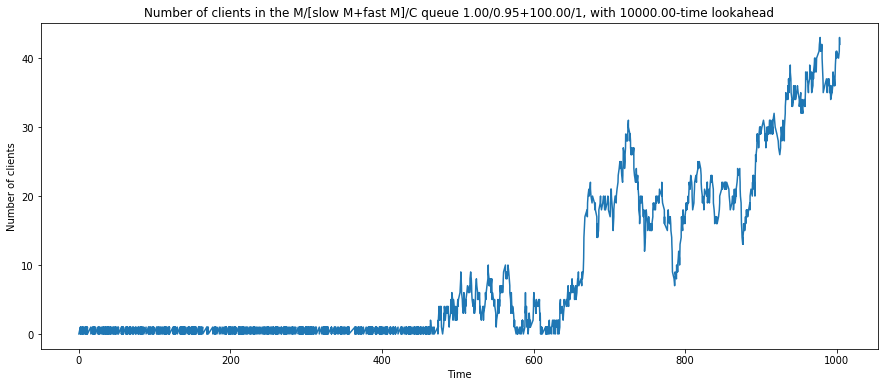

In [47]:

figure(figsize=(15,6))
plot(T[:int(len(T)*0.1)], N[:int(len(T)*0.1)])
xlabel('Time')
ylabel('Number of clients')
title('Number of clients in the M/[slow M+fast M]/C queue %.2f/%.2f+%.2f/%d, with %.2f-time lookahead'
      % (lambd, mu1, mu2, c, w))

In [25]:
'''figure(figsize=(15,6))
title('Average queue length vs. w')
xlabel('w')
ylabel('Average queue length')
plot(ws, w_lookahead_y, label="w-lookahead policy")
legend()
plt.show()'''

'figure(figsize=(15,6))\ntitle(\'Average queue length vs. w\')\nxlabel(\'w\')\nylabel(\'Average queue length\')\nplot(ws, w_lookahead_y, label="w-lookahead policy")\nlegend()\nplt.show()'


80 surge threshold.
Average queue length 66.253
P in surge 0.049
Computed in 0.635 seconds


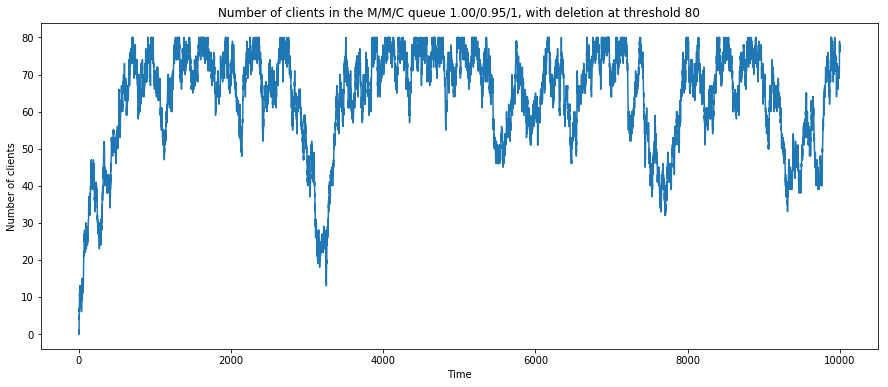

In [42]:
threshold_x = []
threshold_y = []

thresholds = [80]#range(1, 15)

for surge_threshold in thresholds:
    s = """\n%d surge threshold.""" % (surge_threshold)
    print(s)
    start = time.time()
    T, N, W, S, in_surge = MM1WithOneThreshold(lambd, mu1, mu2, surge_threshold, c, N0, Tmax)
    end = time.time()
    figure(figsize=(15,6))
    plot(T,N)
    #plot(T[int(len(T)*0.31):int(len(T)*0.32)], N[int(len(T)*0.31):int(len(T)*0.32)])
    xlabel('Time')
    ylabel('Number of clients')
    title('Number of clients in the M/M/C queue %.2f/%.2f/%d, with deletion at threshold %d'
          % (lambd, mu1, c, surge_threshold))
    
    print("Average queue length %.3f"%(S))
    print("P in surge %.3f"%(in_surge))
    print("Computed in %.3f seconds" % (end-start))
    threshold_x.append(in_surge)
    threshold_y.append(S)

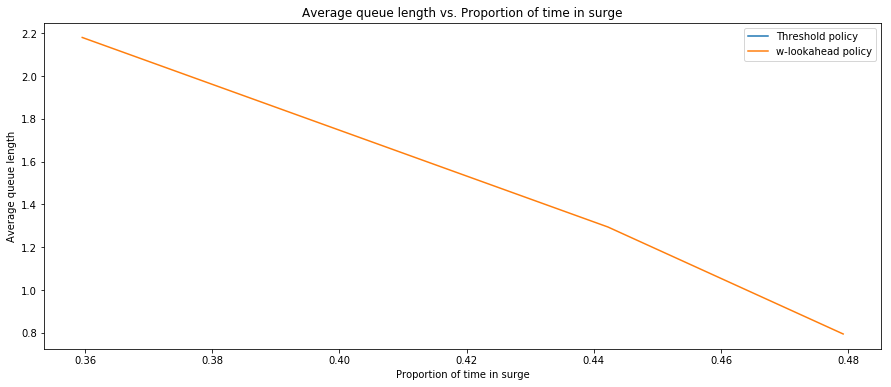

In [39]:
figure(figsize=(15,6))
title('Average queue length vs. Proportion of time in surge')
xlabel('Proportion of time in surge')
ylabel('Average queue length')
plot(threshold_x, threshold_y, label="Threshold policy")
plot(w_lookahead_x, w_lookahead_y, label="w-lookahead policy")
legend()
plt.show()